# Week ahead forecast for Luzon grid electricity demand



In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
from pathlib import os

plt.style.use("ggplot")
plt.rc("figure", figsize=(11, 4))
plt.rc("lines", linewidth=0.5)


In [56]:
file = "luzon_ts.csv"
path = os.path.join("datasets", file)

df = pd.read_csv(path, index_col="Date", parse_dates=True)
print(df.isna().sum())
ts = df.Luzon_load
ts_train = ts[ts.index.year < 2022]
ts_test = ts[ts.index.year == 2022]
df

Luzon_load    0
dtype: int64


,Luzon_load
Date,
2013-01-01 00:00:00,4303
2013-01-01 01:00:00,3918
2013-01-01 02:00:00,3709
2013-01-01 03:00:00,3529
2013-01-01 04:00:00,3450
...,...
2022-12-31 19:00:00,7234
2022-12-31 20:00:00,6952
2022-12-31 21:00:00,6785


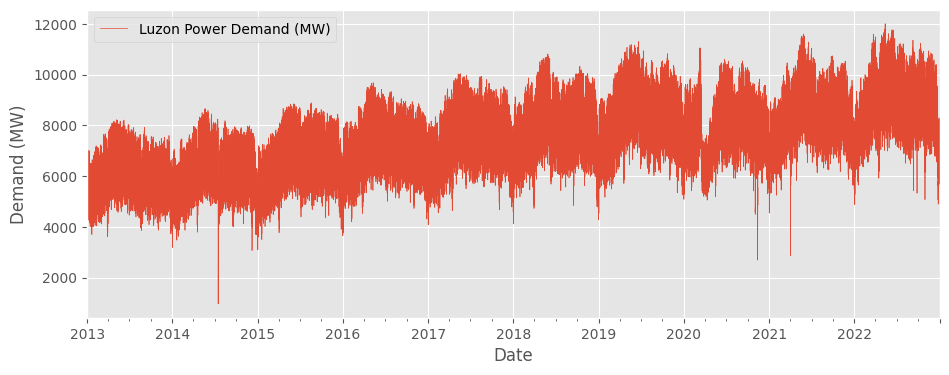

In [3]:
ts.plot(label="Luzon Power Demand (MW)")
plt.legend()
plt.ylabel("Demand (MW)")
plt.show()

We notice the strong yearly seasonality of the time series and the roughly linear trend, which means that a dummy linear trend variable would suffice. We see the effect of the start of the pandemic in the year 2020. We will use indicator variables to minimize its impact.

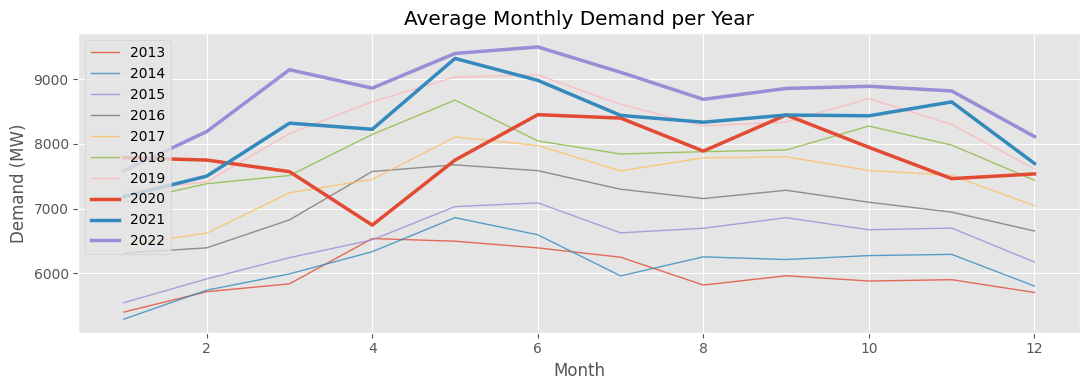

In [71]:
for year in range(2013, 2023):
    idx = ts.index.year == year
    data = ts[idx].groupby(ts[idx].index.month).mean()
    
    if year >= 2020:
        data.plot(label="{}".format(year), linewidth=2.5)
    else:
        data.plot(label="{}".format(year), linewidth=1, alpha=0.8)
    
plt.xlabel("Month")
plt.ylabel("Demand (MW)")
plt.title("Average Monthly Demand per Year")
plt.legend()
plt.tight_layout()

We see that demand starts at its lowest at the start of the year, slowly increases and peaks around the month of July and then slowly decreases again with a discernable drop in the month of December. <br>
We also see the averages for the year 2020 which has an outlier behavior with a sudden drop at the month of March and April due to the lockdowns during that time. Although we see that demand was quick to recover in the years 2021 and 2022.

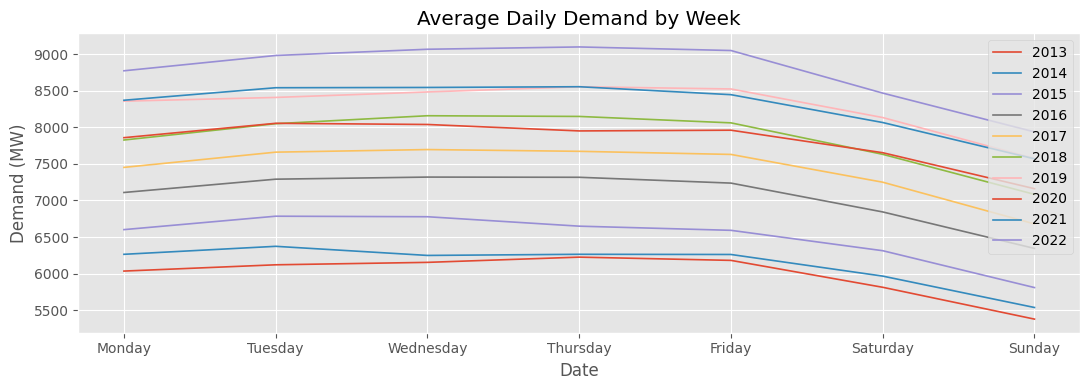

In [72]:
for year in range(2013, 2023):
    idx = ts[ts.index.year == year].index
    
    ts_ = ts[idx]
    ts_.groupby(ts_.index.dayofweek).mean().plot(linewidth=1.2, label="{year}".format(year=year))
    plt.xticks([0, 1, 2, 3, 4, 5 ,6], ["Monday","Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
    
plt.title("Average Daily Demand by Week")
plt.ylabel("Demand (MW)")
plt.legend()
plt.tight_layout()

We see that the demand curve stays relatively constant for weekdays but drops off during weekends.

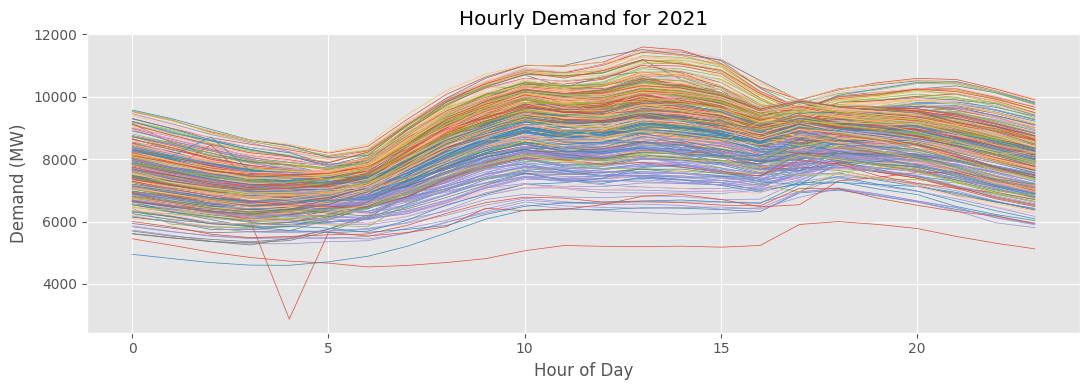

In [73]:
res = []
counter = 1
df_res = pd.DataFrame()    
idx = ts[ts.index.year == 2021].index
ts_ = ts[idx]
day_ofyears = ts_.groupby(ts_.index.dayofyear)

for day in day_ofyears:
    series_ = day[1].to_numpy()
    df_res["day_{day}".format(day=counter)] = pd.Series(series_, index=np.arange(24))
    counter += 1
    
df_res.plot(legend=False)
plt.xlabel("Hour of Day")
plt.ylabel("Demand (MW)")
plt.title("Hourly Demand for 2021")
plt.tight_layout()

We see from the demand curve that the minimum demand occurs around 5 AM then the demand picks up and peaks at around 12 PM to 2 PM. We also see a characteristic dip at 6 PM before demand climbs again as people start to arrive at home from their work.

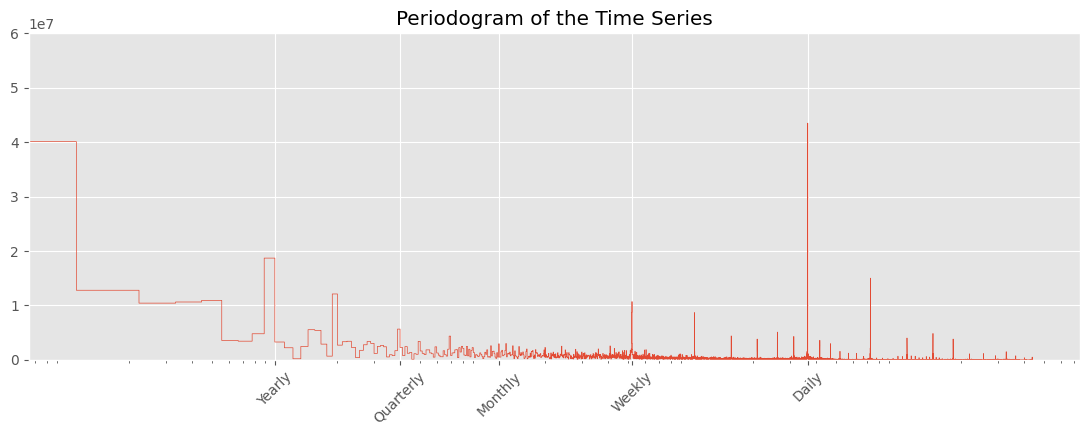

In [11]:
#CREATE PERIODOGRAM
import tensorflow as tf 

fft = tf.signal.rfft(ts[ts.index.year != 2022])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(ts[ts.index.year != 2022])
hours_per_year = 24*365.2524

years_per_dataset = n_samples_h / hours_per_year

f_per_year = f_per_dataset / years_per_dataset

plt.step(f_per_year, np.abs(fft))
plt.xscale("log")
plt.ylim(0, 0.6e8)
plt.tight_layout()
plt.xticks([1, 4, 12, 52.2, 365.25], ["Yearly", "Quarterly", "Monthly", "Weekly", "Daily"])
plt.xticks(rotation=45)

plt.gca().set_title("Periodogram of the Time Series")
plt.show()

We see from the periodogram that we can use a 4th order fourier feature to capture yearly to quarterly seasonality. We see a spike in the weekly and daily seasonality but we will use dummy variables to encode those features.

# Holidays
Let's investigate the effect of holidays on electricity demand, particularly christmas holidays and easter sundays.

In [5]:
holidays_df = pd.read_csv("holiday_data/phl_holidays.csv", index_col=0, parse_dates=True)
holidays_df.head(24)

,name,type,date
0,New Year's Day,Regular Holiday,2013-01-01
1,Maulid un-Nabi,Common local holiday,2013-01-24
2,Lunar New Year's Day,Special Non-working Holiday,2013-02-10
3,People Power Anniversary,Observance,2013-02-25
4,March Equinox,Season,2013-03-20
5,Maundy Thursday,Regular Holiday,2013-03-28
6,Good Friday,Regular Holiday,2013-03-29
7,Black Saturday,Observance,2013-03-30
8,Easter Sunday,Observance,2013-03-31
9,The Day of Valor,Regular Holiday,2013-04-09


In [6]:
holidays_df.type.value_counts()

Regular Holiday                 219
Special Non-working Holiday     147
Season                           72
Observance                       67
Common local holiday             53
Special Working Day              42
Muslim, Common local holiday     18
National holiday                  3
Name: type, dtype: int64

We will probably only retain regular holidays, special non-working holidays, and national holidays as part of our feature space as including all types of holidays will greatly increase the size of our model.

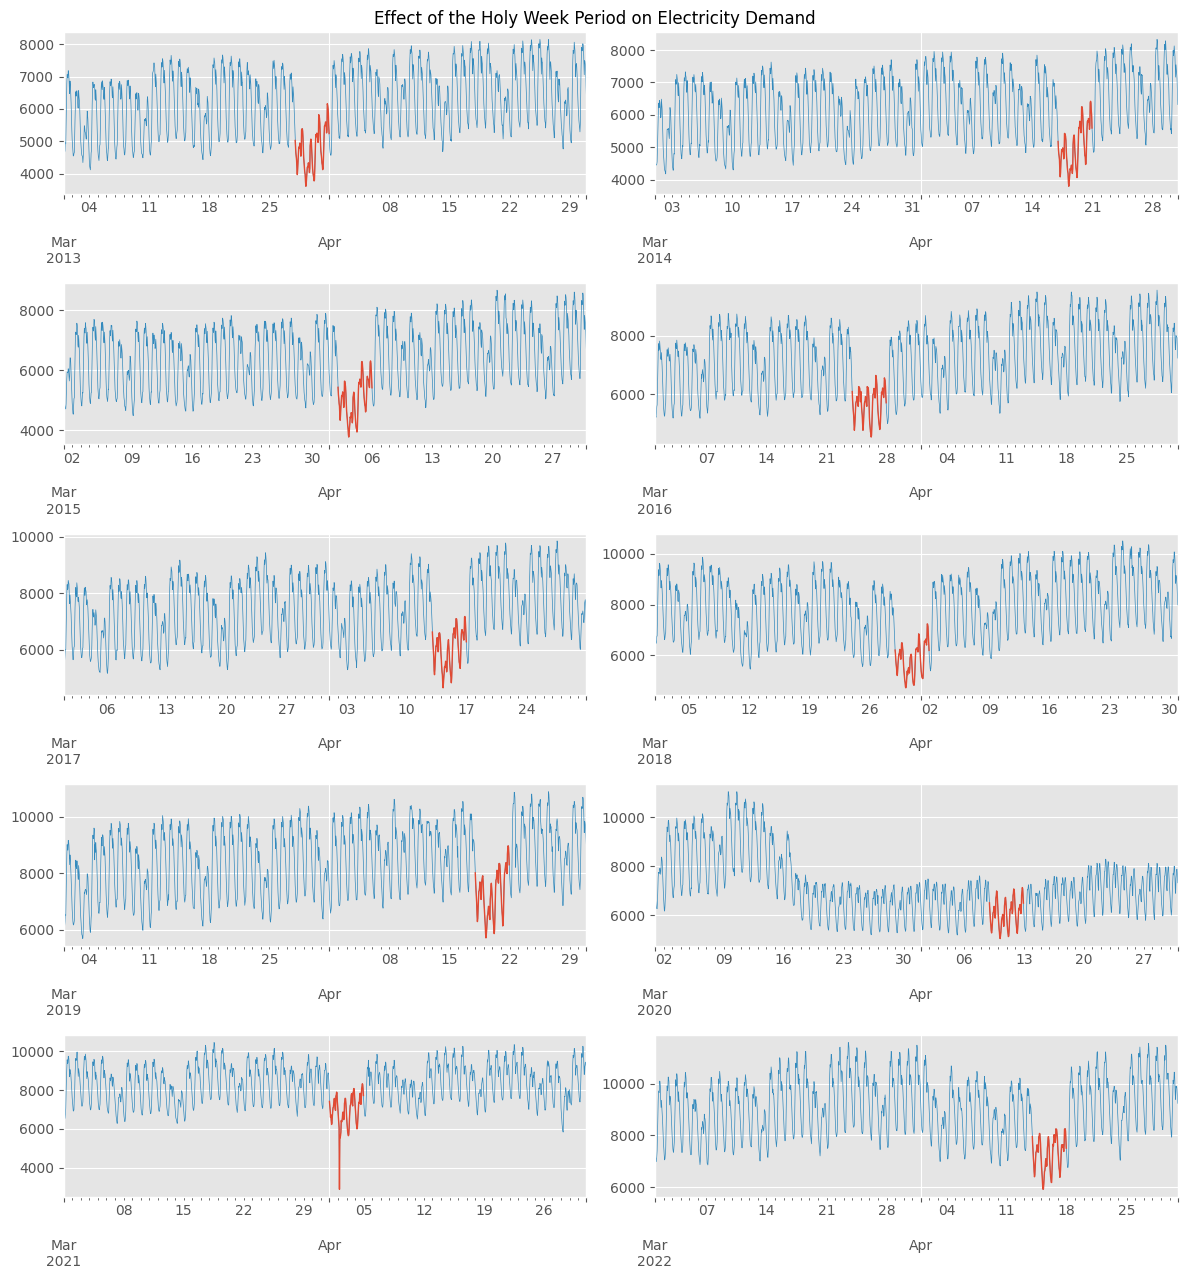

In [7]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(12, 13))
holy_week = holidays_df[holidays_df.name == "Maundy Thursday"][:10]

for i, year in enumerate(range(2013, 2023)):
    start = "{year}-03-01".format(year=year)
    end = "{year}-04-30".format(year=year)

    data = ts[start:end].copy()
    holy_week_idx = pd.date_range(start=holy_week.date.iloc[i], freq="H", periods=24*4)
    
    ax_ = ax[int(i/2), i%2]
    l1 = data.plot(ax=ax_, xlabel="", color="C1")
    l2 = data[holy_week_idx].plot(ax=ax_, xlabel="", color="C0", linewidth=1, label="Holy Week Period")
    
fig.suptitle("Effect of the Holy Week Period on Electricity Demand")
plt.tight_layout()


We see the sudden drop in demand that persists through the Holy Week Period. We will model the effect of the holy week period from other holidays due to the significance of its effect on demand.

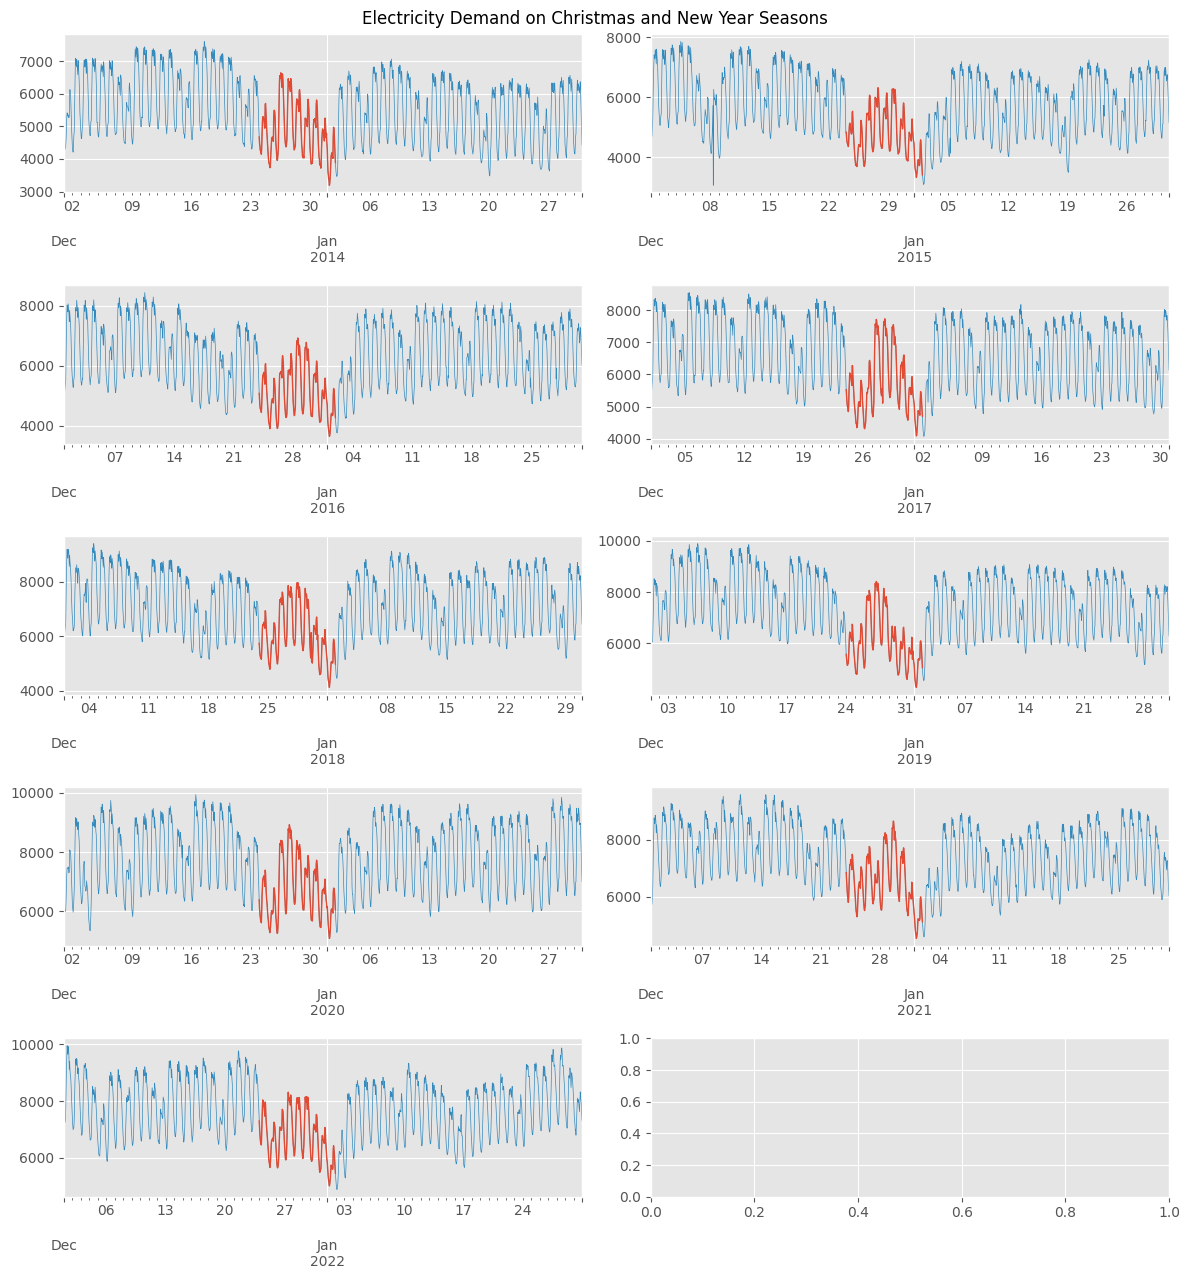

In [8]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(12, 13))
holy_week = holidays_df[holidays_df.name == "Maundy Thursday"][:10]

for i, year in enumerate(range(2013, 2022)):
    start = "{year}-12-01".format(year=year)
    end = "{year}-01-30".format(year=year+1)
    
    start2 = "{year}-12-24".format(year=year)
    end2 = "{year}-01-1".format(year=year+1)
    
    data = ts[start:end]
    
    data.plot(ax=ax[int(i/2), i%2], color="C1")
    data[start2:end2].plot(ax=ax[int(i/2), i%2], color="C0", linewidth=1, xlabel="")
    
fig.suptitle("Electricity Demand on Christmas and New Year Seasons")
plt.tight_layout()


We see that the time between christmas and new year sees lowered electricity demand overall with a noticeable drop on the exact day of their celebration.

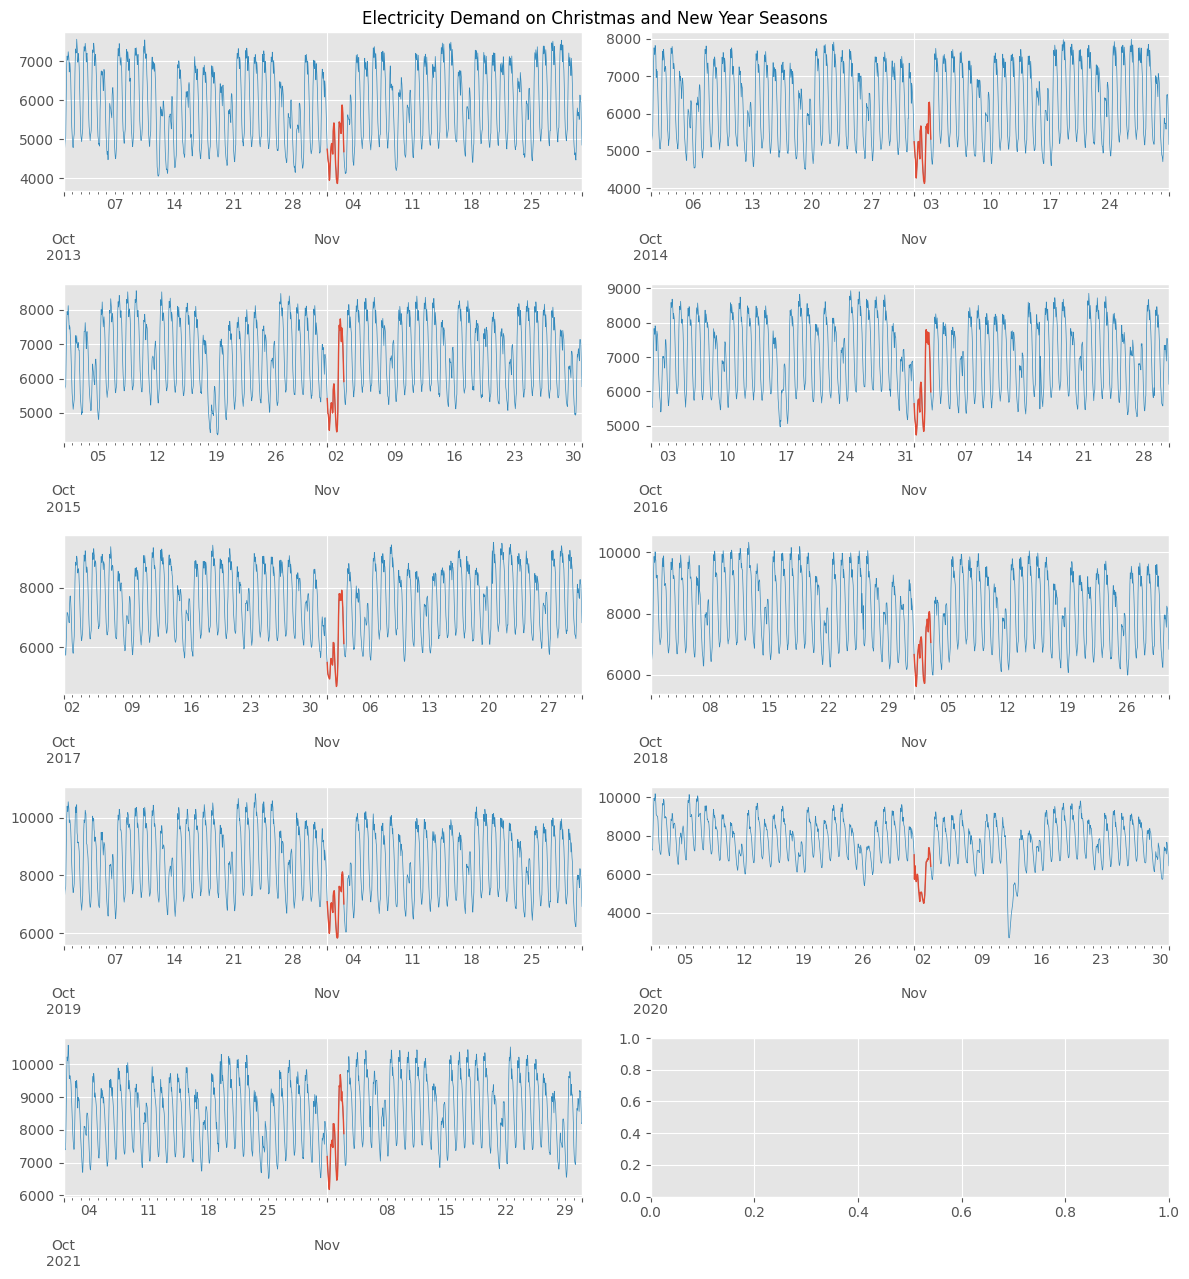

In [9]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(12, 13))
holy_week = holidays_df[holidays_df.name == "All Saints' Day"][:10]

for i, year in enumerate(range(2013, 2022)):
    start = "{year}-10-01".format(year=year)
    end = "{year}-11-30".format(year=year)
    
    start2 = "{year}-11-01".format(year=year)
    end2 = "{year}-11-02".format(year=year)
    
    data = ts[start:end]
    
    data.plot(ax=ax[int(i/2), i%2], color="C1")
    data[start2:end2].plot(ax=ax[int(i/2), i%2], color="C0", linewidth=1, xlabel="")
    
fig.suptitle("Electricity Demand on Christmas and New Year Seasons")
plt.tight_layout()

We see that All Soul's Day just generally affects the day that it is observed.

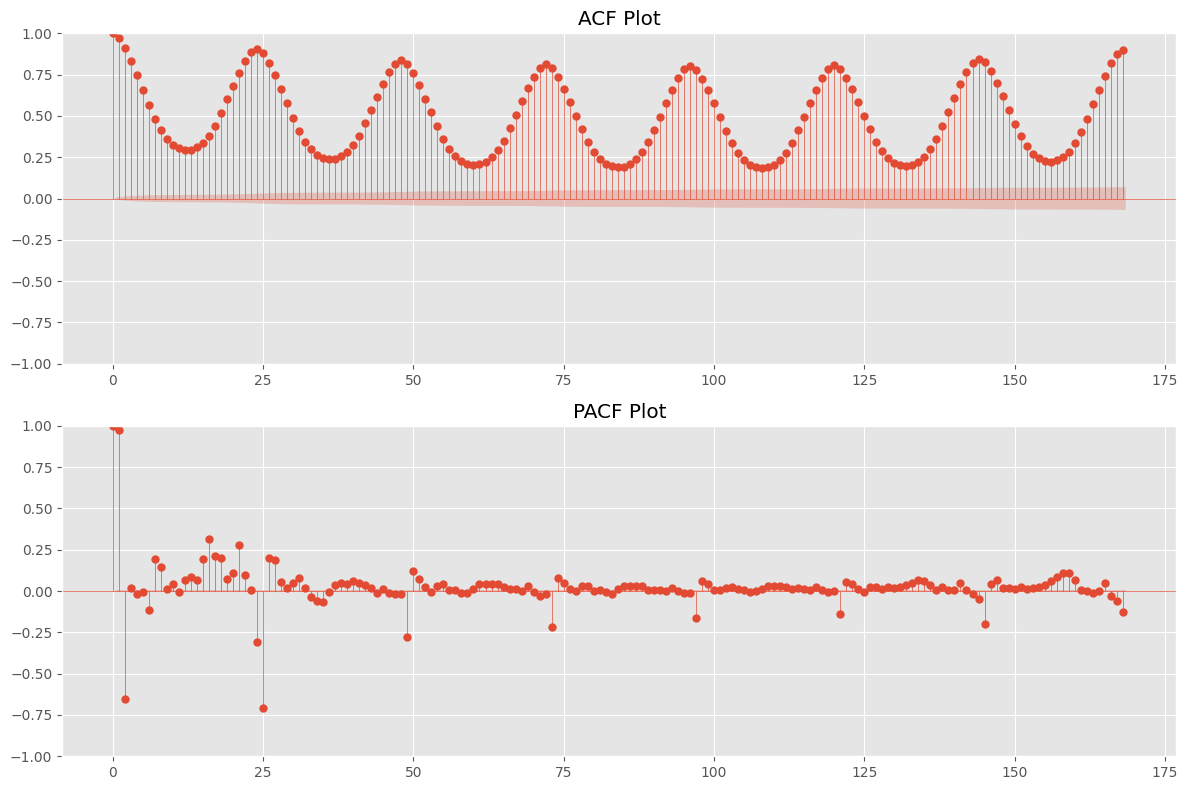

In [10]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))

ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(ts_train, lags=168, ax=ax)
plt.title("ACF Plot")

ax2 = plt.subplot(212)
sm.graphics.tsa.plot_pacf(ts_train, lags=168, ax=ax2)
plt.title("PACF Plot")

plt.tight_layout()

We see from the PACF plot spikes in each of the multile of 24 hours. From the plot we see that the last spike 168 hours prior is still significant, so we can include 168 steps of autoregressive features in our model.

The multiple seasonality characteristic of the time series is evident on the periodogram. We will model the quarterly seasonality through fourier features and the weekly and daily seasonality will be modeled by one-hot-encoded dummy variables. 

## Creating Features and The Model

#### The Features 
The features can be decomposed into three categories, the deterministic, autoregressive, and exogenous features. <br>
The deterministic features include the following:
  * Dummy trend variable
  * Hour of day variable
  * Day of week variable
  * Month of year variable
  * Fourier features (4th order in the case of what we are doing to capture up to quarterly seasonalities)
  * Pandemic const
      * Variable used to indicate the change of level due to the pandemic in 2020
  * Pandemic trend
      * A trend variable used to indicate the change in slope after the pandemic
  * pandemic year
      * A variable used to indicate the year of the start of the pandemic in order to reduce the effects of the pandemic to other variables
  * Holiday indicators
      
Autoregressive features will allow the model to be dynamic and allowv it to adapt values in the near past. In this model, we will use 168 lag values, which is the number of hours used to capture the whole information for the past week before the first point of the forecast. <br>

Exogenous features are extra elements that can be added to a dataset as needed. They are not necessary for building the model, so we include them only if we discover some time series data that shows some correlation with electricity demand. In this particular case, we will be using the daily average temperature as an exogenous feature. We could potentially add more features in the future, but for now, temperature data is the only additional data we have at our disposal.


### The Model


#### Linear Regression Model
The base of the model will be a linear regression model. The forecasting model will be a one-shot model that will predict 168 steps ahead, meaning that this will be a multioutput regression model. One output will equate to a specific step ahead of the forecast origin. This requires 168 linear regression models with each model predicting a specific n-step ahead forecast.  
<br>
#### XGBoost Model
The linear regression model is not expected to capture all of the information available, that is why we use a second and more flexible model, the XGBoost. We will use the xgboost to capture information that is not captured by the LR model. The difference in the training process is that we train the XGBoost regressor on the residuals of the LR model. In short, what we want XGBoost to do is to correct the mistakes of the LR model.
<br><br>
The training sequnce progresses as follows:

**lr model training -> calculate residualts -> train the xgboost using the residuals as targets**
<br><br>
forecasting sequence: <br><br>
$Y_{forecast} = LR_{forecast}+XGBoost_{forecast}$

In [80]:
from sklearn.preprocessing import OneHotEncoder
from statsmodels.tsa.deterministic import CalendarFourier

class DeterministicFeatures():
    """
    This class creates the Deterministic Features used in the time series

    Attributes
    __________
    exog : array-like of shape (n_samples, n_features)
        Contains exogenous regressors if provided.

    ts_index : array-like of shape (n_samples,)
        Contains the datetime index of the time series

    is_fit : Boolean
        Indicates if the model has been fit
        
    X : array-like
        unused
    
    holidays : array-like (pandas DataFrame)
        DataFrame that contains the dates of holidays as its index. Must also contain the
        column name of the holidays and one column each for the year, month, and day of the holidays.

        example:

        -----------------------------------------------
        index   |   name   |  year  |  month  |  day  |
        -----------------------------------------------
        idx1    |  holiday1|  2020  |    1    |   1   |

        All other columns will be ignored.
        
    encoder_daily : obj
        Contains the one-hot-encoder instance for the hourly dummy features.
        
    encoder_weekly : obj
        Contains the one-hot-encoder instance for the weekly dummy features.
    
    encoder_monthly : obj
        Contains the one-hot-encoder instance for the monthly dummy features.
    
    holidays_encoder : obj
        Contains the one-hot-encoder instance for the holidays dummy features.
    """
    def __init__(self):
          
        self.ts = None
        self.ts_index = None
        self.is_fit = False
        self.X = None
        self.holidays = None
        
        self.encoder_daily = None
        self.encoder_weekly = None
        self.encoder_monthly = None
        self.holidays_encoder = None
        
    def fit(self, y, X=None, holidays=None):
        """
        Fit the model to the index of the given time series
        
        X : array-like of index (n_samples, n_features)
            The input exogenous regressors of the time series.
            Must have an index of type datetime64[ns] and must match with the index of y.
            
        y : array-like of index (n_samples,)
            The target values (integers or floats)
            Must have an index of type datetime64[ns] and must match with the index of X.
            
        Returns
        -------
        self : object
            The fitted estimator object.
        """
        if X is not None:
            self.check_data(X, y)
        elif y.index.dtype != "datetime64[ns]":
            raise Exception("Invalid index dtype on y. Must be of type 'datetime64[ns]'")
        
        self.ts_index = y.index
        self.ts = y
        self.exog = X
        self.holidays = holidays
        self.is_fit = True
        
        #fit the transformers
        self.create_weekly_seasonality(index=y.index, fit_only=True)
        self.create_daily_seasonality(index=y.index, fit_only=True)
        self.create_monthly_seasonality(index=y.index, fit_only=True)
        
        if holidays is not None:
            self.generate_holidays(X_new=y, holidays=holidays, fit_only=True)
            
        return self
    
    def transform(self, y, X=None, holidays=None):
        """
        Creates the the output features using the index of X and y
        
        X : array-like of index (n_samples, n_features)
            The input exogenous regressors of the time series.
            Must have an index of type datetime64[ns] and must match with the index of y.
            
        y : array-like of index (n_samples,)
            The target values (integers or floats)
            Must have an index of type datetime64[ns] and must match with the index of X.
            
        Returns
        -------
        X_new : pandas DataFrame object
            The created features from the index of X and y that is joined with the exogenous regressors if given.
        """
        if not self.is_fit:
            raise Exception("The fit function has yet been called. Ensure that the fit function is called before calling the transform method.")
        if X is not None:
            self.check_data(X, y)
        elif y.index.dtype != "datetime64[ns]":
            raise Exception("Invalid index dtype on y. Must be of type 'datetime64[ns]'")
            
        trend = self.create_linear_trend(y.index)
        daily = self.create_daily_seasonality(y.index)
        weekly = self.create_weekly_seasonality(y.index)
        monthly = self.create_monthly_seasonality(y.index)
        fourier = self.create_fourier(y.index)
        pandemic = self.pandemic_changepoint(y.index)
        lags = self.create_lags(y)
        X_new = pd.concat([trend, daily, weekly, monthly, fourier, pandemic, lags], axis=1)
        
        if X is not None:
            X_new = pd.concat([X, X_new], axis=1)
        if holidays is not None:
            X_new = self.generate_holidays(X_new=X_new, holidays=holidays)
        
        X_new.dropna(inplace=True)

        return X_new
        
    def fit_transform(self, y, X=None, holidays=None):
        """
        Fits the model to the data given and creates the the output features using the index of X and y
        
        X : array-like of index (n_samples, n_features)
            The input exogenous regressors of the time series.
            Must have an index of type datetime64[ns] and must match with the index of y.
            
        y : array-like of index (n_samples,)
            The target values (integers or floats)
            Must have an index of type datetime64[ns] and must match with the index of X.
            
        Returns
        -------
        X_new : pandas DataFrame object
            The created features from the index of X and y that is joined with the exogenous regressors if given.
        """
        self.fit(X=X, y=y, holidays=holidays)
        
        return self.transform(X=X, y=y, holidays=holidays)
    
    def check_data(self, X, y):
        
        if X.index.dtype != "datetime64[ns]":
            raise Exception("The index of X is not of type 'datetime64[ns]'")
        if y.index.dtype != "datetime64[ns]":
            raise Exception("The index of y is not of type 'datetime64[ns]'")
        
   
    def create_linear_trend(self, index):
        """
        This method creates the constant and linear trend variables
        
        parameters
        ---------
        index : array-like of shape (n_samples,)
            Contains the index of the time series.
        
        Returns
        -------
        df_trend : pandas DataFrame object
            A pandas dataFrame object that contains the linear trend variable
        """
        df_trend = pd.DataFrame()
        
        #shift trend
        shift = 0
        if index[0] > self.ts.index[0]:
            dates = pd.date_range(start=self.ts.index[0], end=index[0], freq="H")
            shift += len(dates) - 1
        
        df_trend["trend"] = np.arange(len(index)) + shift
        df_trend.index = index
        
        df_trend["pandemic_year"] = np.zeros(len(df_trend))
        df_trend.pandemic_year[df_trend.index.year == 2020] = 1
        
        return df_trend
        
    def create_daily_seasonality(self, index, fit_only=False):
        """
        This method creates the hourly dummy variables
        
        parameters
        ----------
        index : array-like of shape (n_samples,)
            Contains the index of the time series.
        
        fit_only : Boolean
            Tells the method to create and fit the wrapped OneHotEncoder object
        
        Returns
        -------
        daily_encodings : pandas DataFrame object
            A pandas dataFrame object that contains the one-hot-encoded hourly dummy variables
        """
        df_hours = pd.DataFrame(index.hour)
        df_hours.columns = ["hour_"]
        
        if fit_only:
            self.encoder_daily = OneHotEncoder(drop="first", sparse_output=False)
            self.encoder_daily.fit(df_hours)
            return
            
        daily_encodings = self.encoder_daily.transform(df_hours)
        daily_encodings = pd.DataFrame(daily_encodings, 
                                       columns=self.encoder_daily.get_feature_names_out(), 
                                       index=index)
        
        return daily_encodings
    
    def create_weekly_seasonality(self, index, fit_only=False):
        """
        This method creates the weekly seasonal dummy variables
        
        parameters
        ----------
        index : array-like of shape (n_samples,)
            Contains the index of the time series.
        
        fit_only : Boolean
            Tells the method to create and fit the wrapped OneHotEncoder object
        
        Returns
        -------
        daily_encodings : pandas DataFrame object
            A pandas dataFrame object that contains the days of the weeks as one-hot-encoded variables
        """
        df_weeks = pd.DataFrame(index.dayofweek)
        df_weeks.index = index
        df_weeks.columns = ["day_"]
        
        if fit_only:
            self.encoder_weekly = OneHotEncoder(drop="first", sparse_output=False)
            self.encoder_weekly.fit(df_weeks)
            return
        
        weekly_encodings = self.encoder_weekly.transform(df_weeks)
        weekly_encodings = pd.DataFrame(weekly_encodings,
                                       columns=self.encoder_weekly.get_feature_names_out(),
                                       index=index)
        
        return weekly_encodings
    
    def create_monthly_seasonality(self, index, fit_only=False):
        """
        This method creates the monthly seasonal dummy variables
        
        parameters
        ----------
        index : array-like of shape (n_samples,)
            Contains the index of the time series.
        
        fit_only : Boolean
            Tells the method to create and fit the wrapped OneHotEncoder object
        
        Returns
        -------
        monthly_encodings : pandas DataFrame object
            A pandas dataFrame object that contains the days of the weeks as one-hot-encoded variables
        """
        df_months = pd.DataFrame(index.month)
        df_months.index = index
        df_months.columns = ["month_"]
        
        if fit_only:
            self.encoder_monthly = OneHotEncoder(drop="first", sparse_output=False)
            self.encoder_monthly.fit(df_months)
            return
        
        monthly_encodings = self.encoder_monthly.transform(df_months)
        monthly_encodings = pd.DataFrame(monthly_encodings,
                                       columns=self.encoder_monthly.get_feature_names_out(),
                                       index=index)
        
        return monthly_encodings
    
    def create_fourier(self, index, order=4):
        """
        This method creates the weekly seasonal dummy variables
        
        parameters
        ----------
        index : array-like of shape (n_samples,)
            Contains the index of the time series.
            
        order : int
            The order of the fourier features to generate
        Returns
        -------
        in_samples : pandas DataFrame object
            A pandas dataFrame object that contains the fourier features of shape (n_samples, order * 2)
        """
        fourier = CalendarFourier(freq="Y", order=order)
        in_samples = fourier.in_sample(index)
        
        return in_samples
    
    def pandemic_changepoint(self, index=None):
        """
        This method creates const and dummy variable related to the effect of the pandemic
        
        parameters
        ----------
        index : array-like of shape (n_samples,)
            Contains the index of the time series.
            
        Returns
        -------
        df_pandemic : pandas DataFrame object
            A pandas dataFrame object that contains the new const and trend variable of shape (n_samples, 2)
        """
        pandemic_start = "2020-03-01"
        idx = index >= pandemic_start
        df_pandemic = pd.DataFrame()
        
        df_pandemic["const_pandemic"] = np.zeros(len(index))
        df_pandemic["trend_pandemic"] = np.zeros(len(index))
        
        #shift the trend variable by the shift amount
        #shift is the length of time time from the start of the pandemic and the start of the input series
        shift = 0
        if pandemic_start < str(index[0]):
            date_from_start = pd.date_range(start=pandemic_start, freq="H", end=index[0])
            shift = len(date_from_start) - 1
        
        df_pandemic.const_pandemic[idx] = np.ones(idx.sum())
        df_pandemic.trend_pandemic[idx] = np.arange(idx.sum()) + shift 
        
        df_pandemic.index = index

        return df_pandemic
    
    def generate_holidays(self, holidays=None, X_new=None, fit_only=False):
        df_ = pd.DataFrame(index=X_new.index)
        df_["year"] = df_.index.year
        df_["month"] = df_.index.month
        df_["day"] = df_.index.day
        
        #drop_duplicates 
        holidays_ = holidays.drop_duplicates(subset=["year", "month", "day"])
        
        if fit_only:
            self.holidays_encoder = OneHotEncoder(drop="first", sparse_output=False,
                                                 min_frequency=5,
                                                 handle_unknown="infrequent_if_exist")
            self.holidays_encoder.fit(holidays_[["name"]])
            return
        
        df_ = df_.merge(holidays_,how="left", on=["year", "month", "day"])
        df_.fillna(inplace=True, axis=1, value="unknown")
        df_.index = X_new.index
        df_holidays_ = pd.DataFrame(self.holidays_encoder.transform(df_[["name"]]),
                                    index=df_.index,
                                    columns=self.holidays_encoder.get_feature_names_out()
                                   )
        
        return pd.concat([X_new, df_holidays_], axis=1) 
    
    def create_lags(self, ts, lags=168):
        lags_df = pd.DataFrame()
        lags_df.index = ts.index
        
        #create lags from current lag_0 to lag_167
        for lag in range(lags):
            lags_df["lag_{lag}".format(lag=lag)] = ts.shift(lag)
        
        lags_df = lags_df.copy()
        return lags_df 
    
        

In [83]:
%%time
feats = DeterministicFeatures()

#Test create featyres with no holidays and external regressors
feats_df = feats.fit_transform(y=ts_train)
feats_df.head()

CPU times: total: 781 ms
Wall time: 1.41 s


,trend,pandemic_year,hour__1,hour__2,hour__3,hour__4,hour__5,hour__6,hour__7,hour__8,...,lag_158,lag_159,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-07 23:00:00,167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3461.0,3362.0,3292.0,3240.0,3411.0,3450.0,3529.0,3709.0,3918.0,4303.0
2013-01-08 00:00:00,168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3699.0,3461.0,3362.0,3292.0,3240.0,3411.0,3450.0,3529.0,3709.0,3918.0
2013-01-08 01:00:00,169,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3945.0,3699.0,3461.0,3362.0,3292.0,3240.0,3411.0,3450.0,3529.0,3709.0
2013-01-08 02:00:00,170,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3921.0,3945.0,3699.0,3461.0,3362.0,3292.0,3240.0,3411.0,3450.0,3529.0
2013-01-08 03:00:00,171,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,3945.0,3921.0,3945.0,3699.0,3461.0,3362.0,3292.0,3240.0,3411.0,3450.0


In [82]:
holidays_df = pd.read_csv(os.path.join("datasets", "Philippine_holidays.csv"), index_col=0,
                         parse_dates=True, dayfirst=True)

lower_case = lambda s: s.lower()
holidays_df.name = holidays_df.name.map(lower_case)
holidays_df.type = holidays_df.type.map(lower_case)
holidays_df.head()
holidays_df = holidays_df[holidays_df.type.isin(["regular holiday",
                                                "special non-working holiday",
                                                "national holiday"])]
holidays_df

,name,type,year,month,day
2013-01-01,new year's day,regular holiday,2013,1,1
2013-02-10,lunar new year's day,special non-working holiday,2013,2,10
2013-03-28,maundy thursday,regular holiday,2013,3,28
2013-03-29,good friday,regular holiday,2013,3,29
2013-04-09,the day of valor,regular holiday,2013,4,9
...,...,...,...,...,...
2030-11-30,bonifacio day,regular holiday,2030,11,30
2030-12-08,feast of the immaculate conception,special non-working holiday,2030,12,8
2030-12-25,christmas day,regular holiday,2030,12,25
2030-12-30,rizal day,regular holiday,2030,12,30


In [84]:

#Test create features with holidays but no external regressors
feats = DeterministicFeatures()
feats_df = feats.fit_transform(y=ts_train, holidays=holidays_df)
feats_df[pd.to_datetime("2020-02-29 23:00:00"):].tail()

,trend,pandemic_year,hour__1,hour__2,hour__3,hour__4,hour__5,hour__6,hour__7,hour__8,...,name_lunar new year's day,name_maundy thursday,name_national heroes day,name_new year's day,name_new year's eve,name_ninoy aquino day,name_people power anniversary,name_rizal day,name_the day of valor,name_infrequent_sklearn
Date,,,,,,,,,,,,,,,,,,,,,
2021-12-31 19:00:00,78883,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2021-12-31 20:00:00,78884,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2021-12-31 21:00:00,78885,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2021-12-31 22:00:00,78886,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2021-12-31 23:00:00,78887,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [85]:
feats_df_test = feats.transform(y=ts[ts.index.year == 2022], holidays=holidays_df)
feats_df_test.head()

,trend,pandemic_year,hour__1,hour__2,hour__3,hour__4,hour__5,hour__6,hour__7,hour__8,...,name_lunar new year's day,name_maundy thursday,name_national heroes day,name_new year's day,name_new year's eve,name_ninoy aquino day,name_people power anniversary,name_rizal day,name_the day of valor,name_infrequent_sklearn
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-07 23:00:00,79055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2022-01-08 00:00:00,79056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2022-01-08 01:00:00,79057,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2022-01-08 02:00:00,79058,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2022-01-08 03:00:00,79059,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [86]:
print("All features so far")
features_list = list(feats_df.columns)
features_list

All features so far


['trend',
 'pandemic_year',
 'hour__1',
 'hour__2',
 'hour__3',
 'hour__4',
 'hour__5',
 'hour__6',
 'hour__7',
 'hour__8',
 'hour__9',
 'hour__10',
 'hour__11',
 'hour__12',
 'hour__13',
 'hour__14',
 'hour__15',
 'hour__16',
 'hour__17',
 'hour__18',
 'hour__19',
 'hour__20',
 'hour__21',
 'hour__22',
 'hour__23',
 'day__1',
 'day__2',
 'day__3',
 'day__4',
 'day__5',
 'day__6',
 'month__2',
 'month__3',
 'month__4',
 'month__5',
 'month__6',
 'month__7',
 'month__8',
 'month__9',
 'month__10',
 'month__11',
 'month__12',
 'sin(1,freq=A-DEC)',
 'cos(1,freq=A-DEC)',
 'sin(2,freq=A-DEC)',
 'cos(2,freq=A-DEC)',
 'sin(3,freq=A-DEC)',
 'cos(3,freq=A-DEC)',
 'sin(4,freq=A-DEC)',
 'cos(4,freq=A-DEC)',
 'const_pandemic',
 'trend_pandemic',
 'lag_0',
 'lag_1',
 'lag_2',
 'lag_3',
 'lag_4',
 'lag_5',
 'lag_6',
 'lag_7',
 'lag_8',
 'lag_9',
 'lag_10',
 'lag_11',
 'lag_12',
 'lag_13',
 'lag_14',
 'lag_15',
 'lag_16',
 'lag_17',
 'lag_18',
 'lag_19',
 'lag_20',
 'lag_21',
 'lag_22',
 'lag_23',
 '

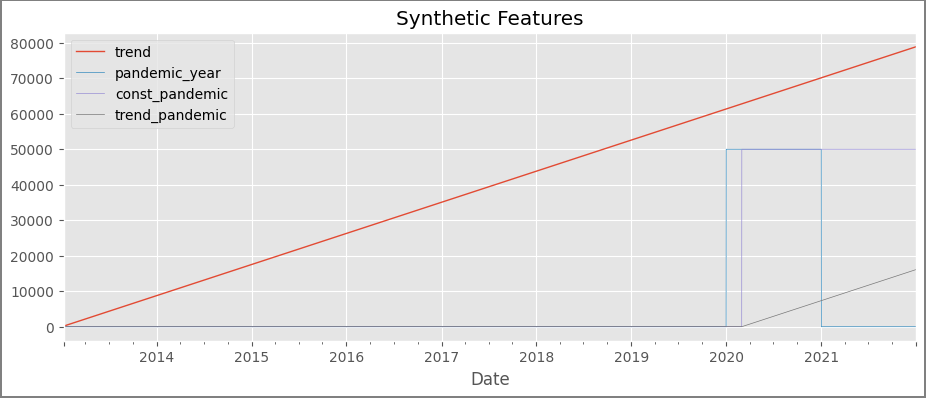

In [87]:
fig = plt.figure(linewidth=1.5)
feats_df.trend.plot(linewidth=1)
(feats_df.pandemic_year * 50000).plot()
(feats_df.const_pandemic * 50000).plot()
(feats_df.trend_pandemic).plot()
plt.title("Synthetic Features")
plt.legend()

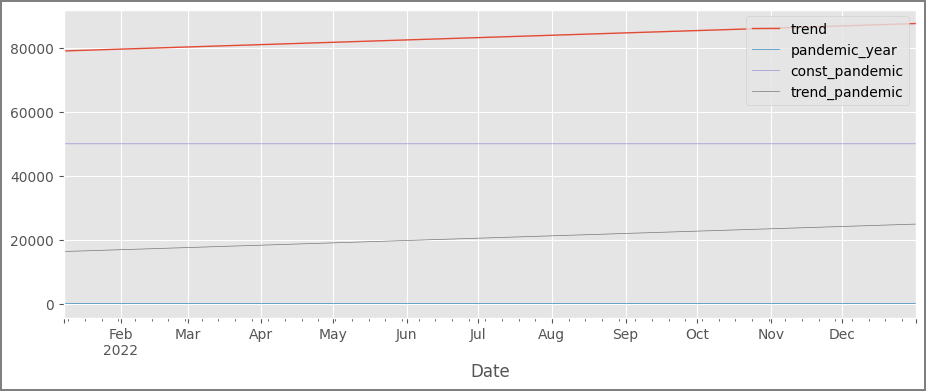

In [88]:
fig = plt.figure(linewidth=1.5)
feats_df_test.trend.plot(linewidth=1)
(feats_df_test.pandemic_year * 50000).plot()
(feats_df_test.const_pandemic * 50000).plot()
(feats_df_test.trend_pandemic).plot()
plt.legend()

In [89]:
#features to use on the xgboost regressor
xgb_feats = []
for feat in features_list:
    if feat[:3] != "lag" and feat not in ["trend", "const_pademic", "trend_pandemic"]:
        xgb_feats.append(feat)
        
xgb_feats


['pandemic_year',
 'hour__1',
 'hour__2',
 'hour__3',
 'hour__4',
 'hour__5',
 'hour__6',
 'hour__7',
 'hour__8',
 'hour__9',
 'hour__10',
 'hour__11',
 'hour__12',
 'hour__13',
 'hour__14',
 'hour__15',
 'hour__16',
 'hour__17',
 'hour__18',
 'hour__19',
 'hour__20',
 'hour__21',
 'hour__22',
 'hour__23',
 'day__1',
 'day__2',
 'day__3',
 'day__4',
 'day__5',
 'day__6',
 'month__2',
 'month__3',
 'month__4',
 'month__5',
 'month__6',
 'month__7',
 'month__8',
 'month__9',
 'month__10',
 'month__11',
 'month__12',
 'sin(1,freq=A-DEC)',
 'cos(1,freq=A-DEC)',
 'sin(2,freq=A-DEC)',
 'cos(2,freq=A-DEC)',
 'sin(3,freq=A-DEC)',
 'cos(3,freq=A-DEC)',
 'sin(4,freq=A-DEC)',
 'cos(4,freq=A-DEC)',
 'const_pandemic',
 'name_black saturday',
 'name_bonifacio day',
 'name_christmas day',
 'name_christmas eve',
 'name_eid al-adha',
 'name_eidul-fitar',
 'name_feast of the immaculate conception',
 'name_good friday',
 'name_independence day',
 'name_labor day',
 "name_lunar new year's day",
 'name_mau

In [196]:
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor

class Model():
    """
    This class performs automatic feature construction and fitting to a time series with datetime index

    Attributes
    __________
    X_train : pandas DataFrame of shape (n_sampels - 167, n_features)
        The crated feature from the series index, exogenous regressors, and holidays if provided.

    y_train : array-like of shape (n_samples - 168, 168)
        Contains the targets for the multioutput regression models.

    data_obj : obj
        The feature constructor generator object
    
    fit_vals : array-like of shape (n_samples - 335, 168)
        The fitted values of the linear regression model
        
    lm_resid : array-like of shape (n_samples - 335, 168)
        The residuals of the linear regression model
        
    lm_model : obj
        The instance of the linear regression model
        
    xgb_model : obj
        The instance of the XGBRegressor model
    
    self.xgb_feats : array-like of shape (n_features,)
        The features to be used in fitting the xgb regressor
    
    """
    def __init__(self):
      
        self.X_train = None
        self.y_train = None
        self.data_obj = None
        
        self.fit_vals = None
        self.lm_resid = None
        
        self.lm_model = LinearRegression()
        self.xgb_model = MultiOutputRegressor(XGBRegressor(max_depth=5,
                                                          n_estimators=50))
        self.xgb_feats = None
    
    def fit(self, y, X=None, holidays=None, xgb_feats=None):
        """
        This method creates the deterministic features from y values and indexes.
        This method also creates the n-step ahead targets from the values of y.
        
        A multiple linear regression model is trained first then its residuals are then
        fed as targets of the multioutput XGBRegressor model. Both models use the same
        set of features, only differing in targets.
        
        parameters
        ----------
        y : array-like of shape (n_samples,)
            Contains the values of the time series. It's index must be of type datetime
            
        X : array-like of shape (n_samples, n_predictors)
            The exogenous regressors that would be added to the feature space of the model
            
        holidays : array-like (pandas DataFrame)
            DataFrame that contains the dates of holidays as its index. Must also contain the
            column name of the holidays and one column each for the year, month, and day of the holidays.
            
            example:
            
            -----------------------------------------------
            index   |   name   |  year  |  month  |  day  |
            -----------------------------------------------
            idx1    |  holiday1|  2020  |    1    |   1   |
            
            All other columns will be ignored.
        Returns
        -------
        self : object
            The fitted model.
        """
        #create the deterministic features using the index of y
        self.data_obj = DeterministicFeatures()
        self.X_train = self.data_obj.fit_transform(y, X=X, holidays=holidays)
        
        #create targets
        self.y_train = self.create_targets(y)
        idx = self.X_train.index.intersection(self.y_train.index)
        
        X_train = self.X_train.loc[idx]
        y_train = self.y_train.loc[idx]
        
        #fit the linear regression model
        self.lm_model.fit(X_train, y_train)
        
        #create fitted values and compute the residuals
        self.fit_vals = self.lm_model.predict(X_train)
        self.resid = y_train - self.fit_vals
        
        #selec xgboost features
        self.xgb_feats = xgb_feats
        if self.xgb_feats is None:
            self.xgb_feats = X_train.columns
        
        #fit the multioutput XGBRegressor on the residuals using the same predictors on the linear regression model
        self.xgb_model.fit(X_train[self.xgb_feats], self.resid)
        
        return self
    
    def predict(self, y, X=None, holidays=None):
        """
        This method creates the deterministic features from y values and indexes.
        This method also creates the n-step ahead targets from the values of y.
        
        A multiple linear regression model is trained first then its residuals are then
        fed as targets of the multioutput XGBRegressor model. Both models use the same
        set of features, only differing in targets.
        
        parameters
        ----------
        y : array-like of shape (n_samples,)
            Contains the values of the time series. It's index must be of type datetime
            
        X : array-like of shape (n_samples, n_predictors)
            The exogenous regressors that would be added to the feature space of the model
            
        holidays : array-like (pandas DataFrame)
            DataFrame that contains the dates of holidays as its index. Must also contain the
            column name of the holidays and one column each for the year, month, and day of the holidays.
            
            example:
            
            -----------------------------------------------
            index   |   name   |  year  |  month  |  day  |
            -----------------------------------------------
            idx1    |  holiday1|  2020  |    1    |   1   |
            
            All other columns will be ignored.
            
        Returns
        -------
        res_df : pandas DataFrame of shape (n_samples - 167, 168)
            The 7-step ahead prediction for each sample point.
        """
        #create the features from y, X, and holidays
        X = self.data_obj.transform(y, X=X, holidays=holidays)
        
        #train the lm and xgboost model
        pred_lm  = self.lm_model.predict(X)
        pred_xgb = self.xgb_model.predict(X[self.xgb_feats])
        
        #add the prediction of the lm and xgboost model
        pred_total = pred_lm + pred_xgb
        
        res_df = pd.DataFrame(pred_total)
        res_df.index = y.index[-len(res_df):]
        res_df.columns = [ "step_" + str(i + 1) for i in range(168)]
        
        return X, res_df

    
    def create_targets(self, ts, lead_time=0, horizon=168):
        """
        This method creates the targets of the model.
        The 7-day ahead prediction will consist of 168 data points which starts immediately 1 hr (1 step)
        ahead of the prediction point.
        Due to the creation of 168 ahead datapoints, the length of the new targets will now be reduced by 168 and the last
        168 datapoints will be truncated.
        
        parameters
        ----------
        ts : array-like of shape (n_samples,)
            Contains the values of the time series. It's index must be of type datetime
            
        horizon : int
            The forecast horizon
        
        lead_time : int
            The length of time from start of point of forecast to the start of the forecast horizon
            ##Unimplemented yet
 
        Returns
        -------
        targets_df : pandas DataFrame of shape (n_samples - 168, 168)
            target dataFrame with each row containing 168 targets that are n+1, n+2, ... , n+168 steps ahead
        """
        targets_df = pd.DataFrame()
        targets_df.index = ts.index


        for i in range(horizon):
            targets_df["fore_step_{step}".format(step=i + 1)] = ts.shift(-i - 1)

        targets_df = targets_df.dropna()

        return targets_df.copy()
    


<AxesSubplot: xlabel='date'>

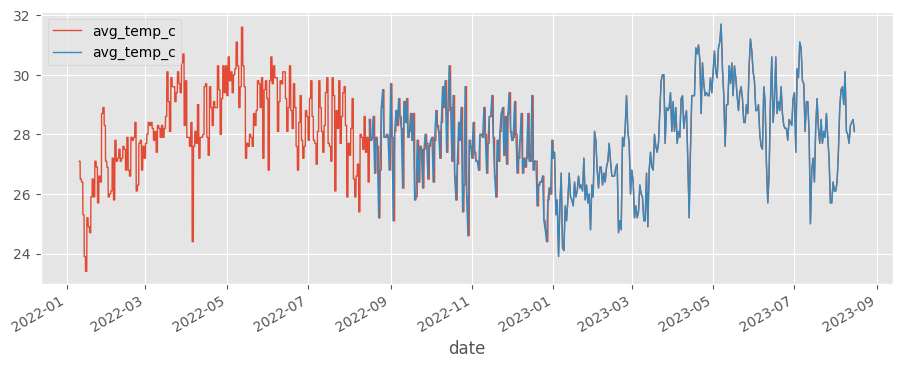

In [197]:
#temperature data as an external regressor
#
temp_df = pd.read_csv("datasets/ph_ave_temp_fromkaggle.csv", index_col=0, parse_dates=True)
temp_df = temp_df[temp_df.index.year > 2013]
temp_df2 = pd.DataFrame(index=ts.index)
temp_df2 = pd.concat([temp_df2, temp_df], axis=1)[8760:]
temp_df2.fillna(inplace=True, method="ffill")

ax = temp_df2[-8760:].plot(linewidth=1)
temp_df[-365:].plot(ax=ax, linewidth=1)

In [198]:
%%time
model1 = Model()
model1.fit(ts_train, holidays=holidays_df, X=temp_df2, xgb_feats=xgb_feats)

CPU times: total: 37min 33s
Wall time: 5min 47s


In [199]:
model1.X_train.head()

,avg_temp_c,trend,pandemic_year,hour__1,hour__2,hour__3,hour__4,hour__5,hour__6,hour__7,...,name_lunar new year's day,name_maundy thursday,name_national heroes day,name_new year's day,name_new year's eve,name_ninoy aquino day,name_people power anniversary,name_rizal day,name_the day of valor,name_infrequent_sklearn
2014-01-01 00:00:00,25.1,8760.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-01 01:00:00,25.1,8761.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-01 02:00:00,25.1,8762.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-01 03:00:00,25.1,8763.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-01 04:00:00,25.1,8764.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [200]:
_, preds = model1.predict(ts_train, holidays=holidays_df, X=temp_df2)

In [201]:
preds.head()

,step_1,step_2,step_3,step_4,step_5,step_6,step_7,step_8,step_9,step_10,...,step_159,step_160,step_161,step_162,step_163,step_164,step_165,step_166,step_167,step_168
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,4027.438800,3756.086076,3552.000035,3474.469611,3413.313099,3162.786861,3204.869467,3384.528919,3637.214301,3789.588478,...,6733.317506,6301.226016,6751.371121,6598.022063,6565.173635,6230.474965,5936.928515,5550.728086,5006.197209,4955.025890
2014-01-01 01:00:00,3633.848301,3477.430685,3356.684352,3301.577869,3122.781651,2992.803155,3022.344771,3350.312303,3505.535453,3973.716424,...,6235.344630,6690.186405,6656.917702,6553.896632,6359.825204,5917.015441,5533.171584,5142.498240,4853.111691,4700.002538
2014-01-01 02:00:00,3437.989958,3380.164538,3245.419829,3079.158694,3000.106242,3122.978357,3399.411526,3474.684706,3798.005755,3958.007496,...,6710.546611,6783.200664,6582.255607,6322.171595,5956.515729,5635.842217,5157.455890,4976.189670,4632.835097,4553.837082
2014-01-01 03:00:00,3427.498257,3375.770977,3157.258735,3132.780824,3155.085218,3304.813675,3650.740831,3793.975862,3903.990255,3998.354429,...,6763.927258,6641.631440,6327.760992,5991.959121,5633.036752,5251.004544,4926.068206,4677.773160,4372.198510,4446.054291
2014-01-01 04:00:00,3332.794616,3105.976932,3147.047375,3135.171067,3323.785389,3597.672631,3984.638460,3957.630236,3852.001993,3763.540336,...,6637.891874,6305.174051,6024.013686,5627.851889,5386.094976,5036.818598,4645.864827,4432.320584,4435.097395,4646.101088


In [202]:
%%time
X_fore, forecast = model1.predict(ts[ts.index.year == 2022], holidays=holidays_df, X=temp_df2)

CPU times: total: 14.5 s
Wall time: 4.88 s


In [203]:
forecast.head()

,step_1,step_2,step_3,step_4,step_5,step_6,step_7,step_8,step_9,step_10,...,step_159,step_160,step_161,step_162,step_163,step_164,step_165,step_166,step_167,step_168
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-07 23:00:00,6895.318269,6723.030482,6591.033076,6463.129709,6539.056631,6689.904822,6809.065676,7385.080379,7719.911022,8247.565497,...,9004.483516,8877.614337,8620.339175,8918.866040,8781.713863,8635.167061,8355.597775,8021.858227,7845.728638,7574.944448
2022-01-08 00:00:00,6664.683917,6492.033459,6396.517808,6424.587109,6512.415284,6797.252563,7260.345383,7336.939160,7366.739811,7868.011472,...,8602.204880,8408.786756,8763.004579,8779.687659,8456.680838,8332.383463,7882.680182,7603.060396,7454.045706,7231.662777
2022-01-08 01:00:00,6587.211145,6532.858546,6540.953364,6614.226630,6774.987542,7426.731436,7823.266955,7799.683462,7745.735792,7976.541414,...,8383.109175,8774.506324,8793.856773,8661.706145,8312.480507,8109.488169,7631.766562,7384.856629,7270.581179,7078.326038
2022-01-08 02:00:00,6545.536142,6597.322338,6640.969785,6776.818363,7258.364960,7843.417236,8260.549547,8210.393460,7791.217635,7985.384562,...,8706.304038,8787.357099,8636.411511,8477.991716,8051.000334,7822.867276,7375.712896,7164.655724,7114.707890,6990.833247
2022-01-08 03:00:00,6530.748106,6618.992401,6781.626599,7311.466221,7752.096787,8225.818530,8510.690150,8162.524325,7816.212355,8163.896223,...,8654.890672,8562.769886,8386.702750,8149.887355,7698.285844,7506.035726,7093.410303,6947.642063,6924.015687,6853.885535


# Performance 

In [204]:
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error as mae

def get_metrics(y, preds):
    y = model1.create_targets(y)
    preds = preds.copy()
    
    idx = y.index.intersection(preds.index)
    
    y = y.loc[idx].to_numpy().flatten()
    preds = preds.loc[idx].to_numpy().flatten()
    
    if type(y) != np.ndarray:
        y = y.to_numpy()
    if type(preds) != np.ndarray:
        preds = preds.to_numpy()
    y = y.flatten()
    preds = preds.flatten()
    
    mape_ = mape(y, preds)
    mae_ = mae(y, preds)
    
    return pd.Series([mape_ * 100, mae_], index=["mape", "mae"])

print("In-sample loss: ")
display(get_metrics(ts_train, preds))
print("Out-of-sample loss: ")
display(get_metrics(ts_test, forecast))

In-sample loss: 


mape      3.204793
mae     225.449658
dtype: float64

Out-of-sample loss: 


mape      4.294769
mae     360.980606
dtype: float64

In [205]:
def match_data(y, preds, model):
    y_ = model.create_targets(y)
    idx = y_.index.intersection(preds.index)
    
    return y_.loc[idx], preds.loc[idx]

In [206]:
y_true, y_preds = match_data(ts_test, forecast, model=model1)

In [207]:
mapes = []
maes = []
variance = []

for col in range(168):
    pred = y_preds[y_preds.columns[col]]
    actual = y_true[y_true.columns[col]]
    mapes.append(mape(actual, pred) * 100)
    maes.append(mae(actual, pred))
    variance.append((actual - pred).std() ** 2)

by_step_metrics = pd.DataFrame([mapes, maes, variance]).T
by_step_metrics.columns = ["MAPE", "MAE", "Variance"]
by_step_metrics["StdErr"] = by_step_metrics.Variance ** 0.5
by_step_metrics

,MAPE,MAE,Variance,StdErr
0,0.727985,63.338395,8684.238374,93.189261
1,1.155579,100.376631,20104.719133,141.791111
2,1.540684,133.585680,34330.742055,185.285569
3,1.797105,155.455258,45635.663143,213.625053
4,2.031856,175.306078,56841.412792,238.414372
...,...,...,...,...
163,4.749250,398.173278,293427.978884,541.689929
164,4.807558,403.674316,295689.916647,543.773773
165,4.803170,402.576455,299927.266475,547.656157
166,4.665362,390.553279,287500.801677,536.191012


Text(0.5, 1.0, 'Loss Metrics as a Function of Forecast Steps')

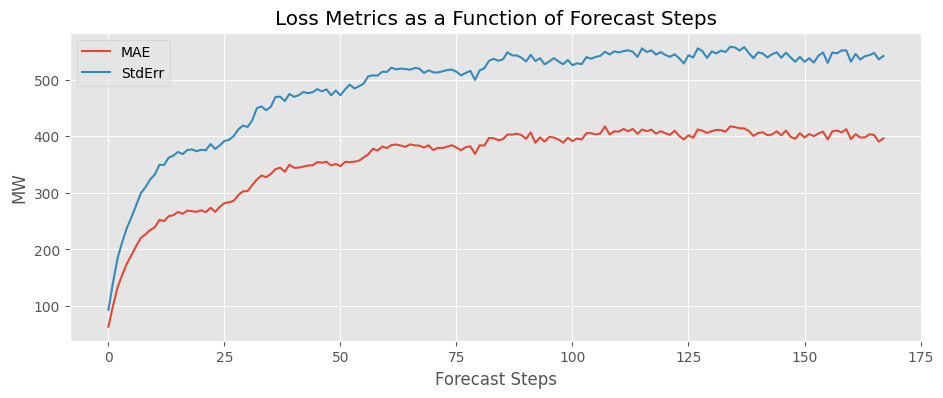

In [146]:
by_step_metrics[["MAE", "StdErr"]].plot(linewidth=1.5)
plt.xlabel("Forecast Steps")
plt.ylabel("MW")
plt.title("Loss Metrics as a Function of Forecast Steps")

In [208]:
def plot_per_week(y, y_pred, index, ax=None):
    idx_range = pd.date_range(start=index, freq="H", periods=169)[1:]
    
    y_ = y.loc[index]
    y_.index = idx_range
    
    y_pred_ = y_pred.loc[index]
    y_pred_.index = idx_range
    
    y_.plot(label="Actual", linewidth=1.5, ax=ax)
    y_pred_.plot(label="Forecast", linewidth=1.5, ax=ax)

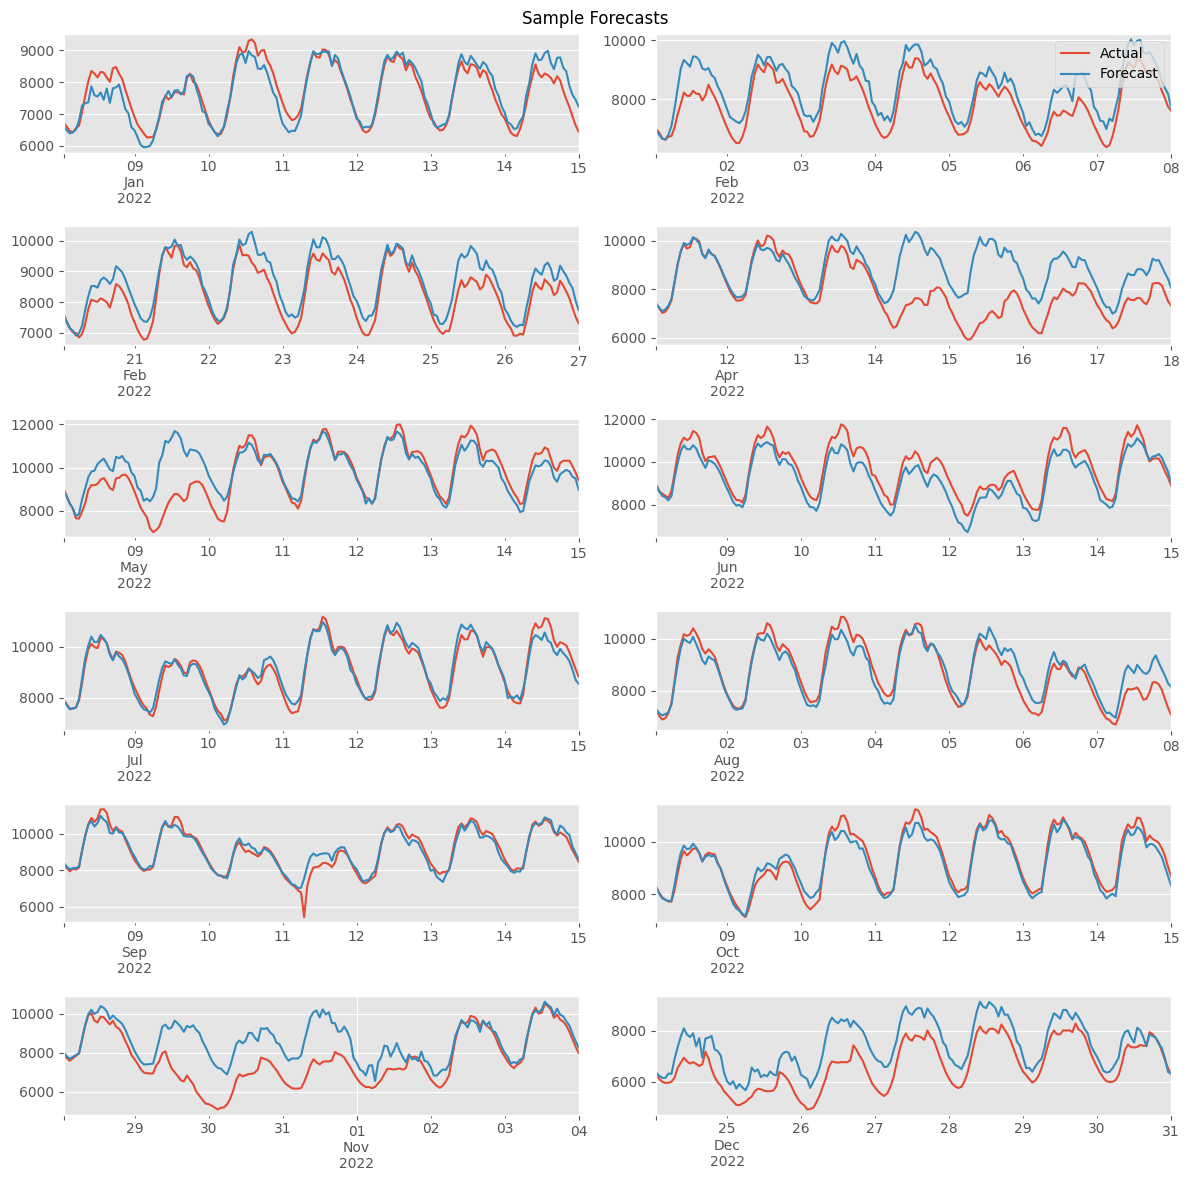

In [256]:
start = ["2022-01-08 00:00:00",
         "2022-02-01 00:00:00",
         "2022-02-20 00:00:00",
         "2022-04-11 00:00:00",
         "2022-05-08 00:00:00",
         "2022-06-08 00:00:00",
         "2022-07-08 00:00:00",
         "2022-08-01 00:00:00",
         "2022-09-08 00:00:00",
         "2022-10-08 00:00:00",
         "2022-10-28 00:00:00",
         "2022-12-24 00:00:00"]


fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(12,12))

for i in range(12):
    plot_per_week(y_true, y_preds, index=start[i], ax=ax[int(i/2), i % 2])

ax[0,1].legend(loc="upper right")
fig.suptitle("Sample Forecasts")
plt.tight_layout()


# CONCLUSION

The test set MAPE and MAE is around 4.29% and 361 MW respectively. I think that this is a fairly good result. I don't have access to data for the forecasts made by the NGCP or the WESM so i can't objectively rate the performance of the model.

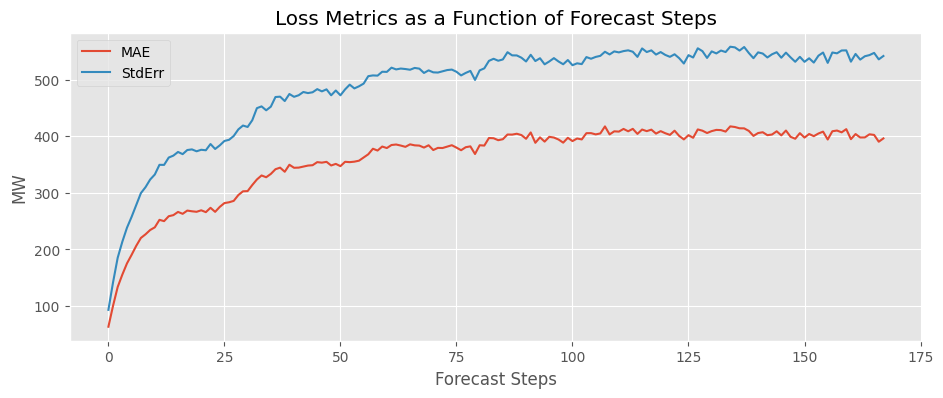

We see that the most accurate forecasts are the points near the forecast origin, as expected. A slightly surpringsing result is that after 3 days or around 72 steps ahead, we see that the mean absolute error levels out and stays at 400 MW for until the end of the forecast horizon. The standard error follows the same behavior, albeit it levels out at 550 MW instead. This means that the forecasts for 7th day ahead are as accurate as the forecasts made for around the 3rd, 4th, 5th, and 6th days ahead.

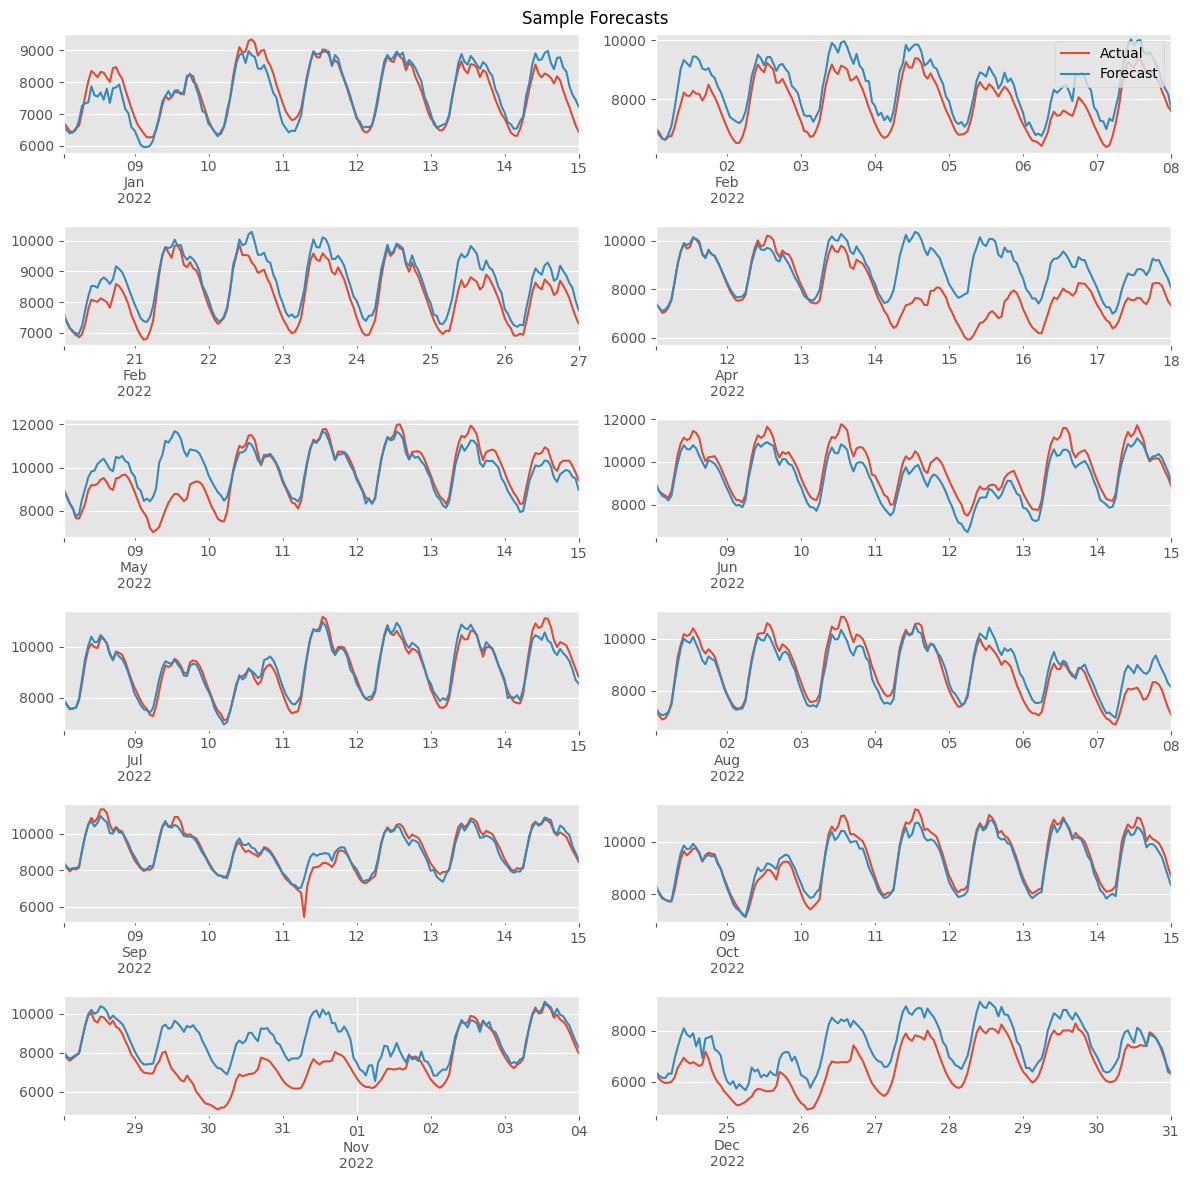

Looking at our sample forecasts, they do look good apart some outliers that we will discuss.

   * The April Forecast
     * The most egregious errors were made in April during the holy week period. I have yet to discover the reason for this as I have ensured that the holiday indicator variable is present on the test set. In comparison, we see that the fitted values on the holy week on the previous year (Plot included below for reference) yielded good results. We also see from the graph that the forecasts from November 1 and 2, which are major holidays in the Philippines, are great, indicating that our holiday variables does indeed work. I will look into this further when i have the time by looking at the weights of each of the 168 linear regressors.
   * May 9, 2020
     * The explanation for the large error is easier as we know that the Presidential election was held at the same date
   * End of October
     * We see that the forecast for November 1 and 2 are great, probably due to the holiday indicator variables. The problem are the forecasts from October 29, 30, and 31. The reasoning could be that the President declared October 31, which is on a Monday, as a holiday. This probably created a synergistic effect due to the fact that October 28-29 is a weekend, and thus a 5-day long weekend is created which enabled a larger number people to go to their provinces, overall drastically lowering electricity demand.
   * Christmas Season
     * The errors for the christmas season is not that bad but the consistent overforecasts during the period should be kept in mind.

To reiterate, the forecast plots look good, apart from a few outliers, there were no systematic errors that we can discern. I think that the model could be improved by adding external regressors such as humidity, improved custom holiday indicators, and economic indicators such as gdp growth per quarter.


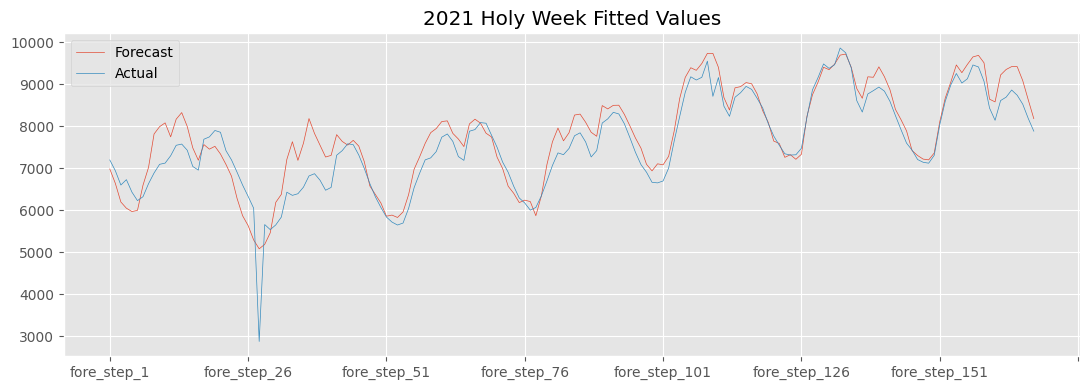

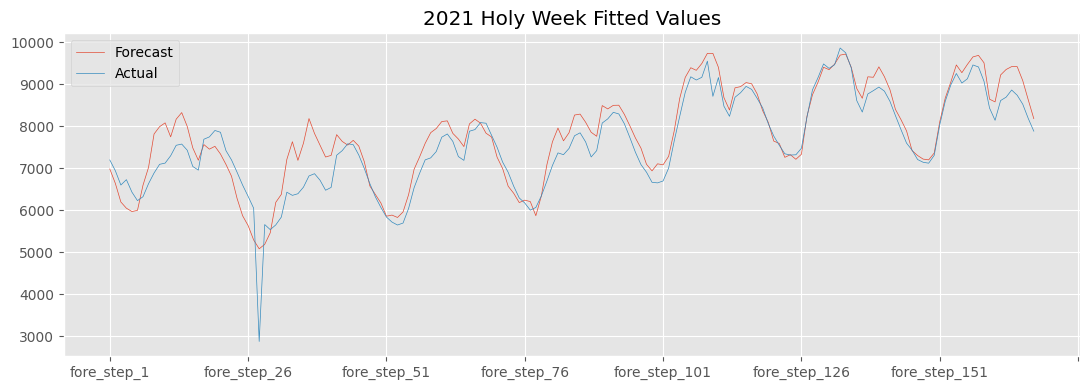

In [251]:
preds.loc["2021-04-01 00:00:00"].plot(label="Forecast")
model1.y_train.loc["2021-04-01 00:00:00"].plot(label="Actual")
plt.title("2021 Holy Week Fitted Values")
plt.legend()
plt.tight_layout()

In [194]:
holidays_df[holidays_df.index.year == 2022]

,name,type,year,month,day
2022-01-01,new year's day,regular holiday,2022,1,1
2022-02-01,lunar new year's day,special non-working holiday,2022,2,1
2022-02-25,people power anniversary,special non-working holiday,2022,2,25
2022-04-09,the day of valor,regular holiday,2022,4,9
2022-04-14,maundy thursday,regular holiday,2022,4,14
2022-04-15,good friday,regular holiday,2022,4,15
2022-04-16,black saturday,special non-working holiday,2022,4,16
2022-05-01,labor day,regular holiday,2022,5,1
2022-05-03,eidul-fitar holiday,regular holiday,2022,5,3
2022-05-09,national and local election holiday,special non-working holiday,2022,5,9


<AxesSubplot: >

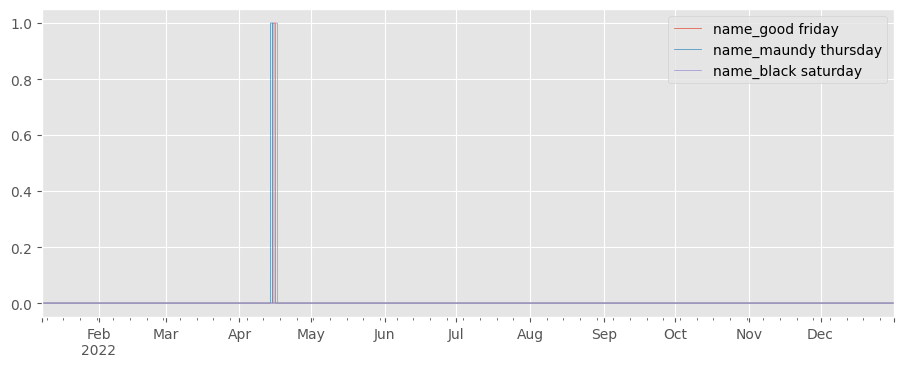

In [252]:
X_fore[["name_good friday", "name_maundy thursday", "name_black saturday"]].plot()